# Spiral extraction methodology

1. Obtain Sérsic parameters of galaxy from NSA catalog
2. Cluster drawn poly-lines
    1. Deproject drawn arms
    2. Cluster using DBSCAN and a custom metric
    3. Use Local Outlier Factor to clean points
    4. Use Local Outlier Factor to identify a "most representative arm"
    5. Sort points in cluster along most representative arm
    6. Fit a smoothing spline to ordered points
3. Calculate pitch angles for the resulting spline fits

Setup the environment:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import requests
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from PIL import Image
from skimage.transform import rotate, rescale
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
import spiralExtraction
import sdssCutoutGrab as scg

Add a little helper function for later

In [3]:
deNormArm = lambda a: 512 * (a + 0.5)

## 1. Obtaining Sérsic parameters

The first step in the process is to deproject the galaxy (and the classifications) using details found in the NASA Sloan Atlas.

The NSA information has been pre-fetched, though the process can be seen in other notebooks.

In [4]:
gal = {
    'RA': 160.65881, 'DEC': 23.95191, 'Z': 0.043594,
    'RUN': 5137, 'CAMCOL': 6, 'FIELD': 314, 'RERUN': 301,
    'SERSIC_BA': 0.576469, 'SERSIC_PHI': 43.1215,
    'PETRO_THETA': 22.2729,
}
subjectId = 14813274

Load in the classifications and subject information:

In [5]:
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

classifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5638 entries, 0 to 5637
Data columns (total 14 columns):
classification_id    5638 non-null int64
user_name            5638 non-null object
user_id              4041 non-null float64
user_ip              5638 non-null object
workflow_id          5638 non-null int64
workflow_name        5638 non-null object
workflow_version     5638 non-null float64
created_at           5638 non-null object
gold_standard        0 non-null float64
expert               0 non-null float64
metadata             5638 non-null object
annotations          5638 non-null object
subject_data         5638 non-null object
subject_ids          5638 non-null int64
dtypes: float64(4), int64(3), object(7)
memory usage: 616.7+ KB


We'll use a helper function from the `spiralExtraction` script to grab all the drawn spiral classifications we'll want

In [6]:
drawnArms = spiralExtraction.getDrawnArms(subjectId, classifications)
print('Found {} arms'.format(len(drawnArms)))

Found 65 arms


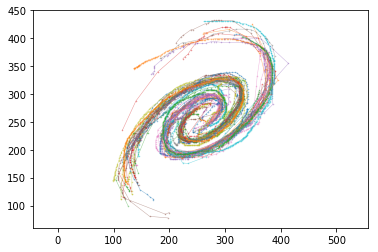

In [7]:
plt.axis('equal')
for arm in drawnArms:
    plt.plot(arm[:, 0], arm[:, 1], '.-', linewidth=0.5, markersize=1, alpha=0.5)

The next step is to deproject the image of the galaxy. For this we need the original FITS file of the image

In [8]:
# Lookup the source fits file (needed for the rotation matrix)
fname = 'fitsImages/{0}/{1}/frame-r-{0:06d}-{1}-{2:04d}.fits'.format(
    int(gal['RUN']),
    int(gal['CAMCOL']),
    int(gal['FIELD'])
)
print('Source fits file:', fname)

Source fits file: fitsImages/5137/6/frame-r-005137-6-0314.fits


We'll also grab the image that was shown to volunteers

In [9]:
url = 'https://panoptes-uploads.zooniverse.org/production/subject_location/6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10.png'
print('URL of galaxy image:')
print(url)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

URL of galaxy image:
https://panoptes-uploads.zooniverse.org/production/subject_location/6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10.png


Grab a WCS object from the fits file, and then use it to engineer a WCS object for the galaxy image (needed as we interpolated the image up to 512x512 pixels)

In [10]:
# Load a WCS object from the FITS image
wFits = WCS(fname)
print('\n\nWCS from fits image:', wFits)

# The SDSS pixel scale is 0.396 arc-seconds
fits_cdelt = 0.396 / 3600

phi = float(gal['SERSIC_PHI'])

# cutouts were chosen to be 4x Petrosean radius, and then scaled (including interpolation) to be 512x512 pixels
scale = 4 * (float(gal['PETRO_THETA']) / 3600) / 512

# This should be obtained from the image, as some were not square.
size_pix = np.array([512, 512])

# Create a new WCS object
w = WCS(naxis=2)
w.wcs.crpix = size_pix / 2
w.wcs.crval = np.array([float(gal['RA']), float(gal['DEC'])])
w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
w.wcs.cunit = ['deg', 'deg']

# Copy the rotation matrix from the source FITS file, adjusting the scaling as needed
w.wcs.cd = [
    wFits.wcs.cd[0] / fits_cdelt * scale,
    wFits.wcs.cd[1] / fits_cdelt * scale
]

print('\n\nCreated WCS:')
print(w)



WCS from fits image: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 160.58559477  23.9670679406  
CRPIX : 1025.0  745.0  
CD1_1 CD1_2  : -1.92462688617e-05  0.000108307970595  
CD2_1 CD2_2  : 0.000108317299457  1.92097370132e-05  
NAXIS : 2048  1489


Created WCS:
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 160.65881  23.95191  
CRPIX : 256.0  256.0  
CD1_1 CD1_2  : -8.457035624403367e-06  4.759178894936426e-05  
CD2_1 CD2_2  : 4.75958881604288e-05  8.440983102929732e-06  
NAXIS : 0  0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Now for a bit of (quite simple) trigonometry to obtain our isophote rotation in image coordinates

In [11]:
r = float(gal['PETRO_THETA'])/3600

cx, cy = 256, 256
wCx, wCy = float(gal['RA']), float(gal['DEC'])

# find our line in world coordinates
x = r * np.sin(np.deg2rad(phi)) + wCx
y = r * np.cos(np.deg2rad(-phi)) + wCy

v = np.array([x - wCx, y - wCy])
v /= np.linalg.norm(v)

ra_line, dec_line = w.wcs_world2pix([wCx, x], [wCy, y], 0)

axis_vector = np.subtract.reduce(
    np.stack(
        (ra_line, dec_line),
        axis=1
    )
)
normal_vector = np.dot([[0, 1], [-1, 0]], axis_vector) * float(gal['SERSIC_BA']) 
origin = np.array([cx, cy])

angle = 180 * np.arccos(axis_vector[1]/np.linalg.norm(axis_vector))/ np.pi
print('Identified angle as: {}'.format(angle))

Identified angle as: 140.62568014839408


Let's visualise this isophote to make sure things look right

(-0.5, 511.5, -0.5, 511.5)

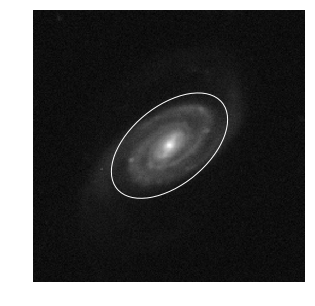

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(np.array(pic), cmap='gray', origin='lower')

t = np.linspace(0, 1, 500)
    
e = Ellipse(
    xy=(256, 256),
    width=256 * gal['SERSIC_BA'],
    height=256,
    angle=90-angle,
    ec='w',
    fc='none'
)
ax.add_artist(e)
plt.axis('off')

This results in our image looking like this after stretching:

/Users/tlingard/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 511.5, -0.5, 511.5)

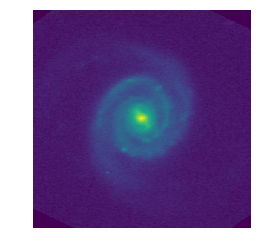

In [13]:
rotatedImage = rotate(np.array(pic), 90-angle)
stretchedImage = rescale(rotatedImage, (1, 1/float(gal['SERSIC_BA'])))
n = int((stretchedImage.shape[1] - np.array(pic).shape[1]) / 2)

if n > 0: deprojectedImage = stretchedImage[:, n:-n]
else: deprojectedImage = stretchedImage.copy()

plt.imshow(deprojectedImage, origin='lower')
plt.axis('off')

Fantastic! We now have all the data we need to start clustering the drawn arms.

## 2. Clustering arms

We will make use of the `spiralExtraction` script, rather than re-defining all the functions here. Those interested in the clustering methodology should read the code, or the method paper (TODO link)

The $\theta - 90$ comes from the differences between Zooniverse coordinates and normal plotting coordinates (top left vs bottom left origins)

In [14]:
res = spiralExtraction.fit(
    drawnArms,
    fullOutput=True
)
print('Avaliable keys:', ', '.join(res.keys()))

Calculating distance matrix (this can be slow)
Clustering arms
Working on arm label 0
	[1 / 4] Cleaning points (3058 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
Working on arm label 1
	[1 / 4] Cleaning points (2610 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
done!
Avaliable keys: distances, functions, labels, LOF


The full output of the fitting pipeline contains the distance matrix calculated when clustering arms, the resulting arm labels, the Local Outlier Factors for each cluster and the spline functions fit.

Let's look at the arm clusters:

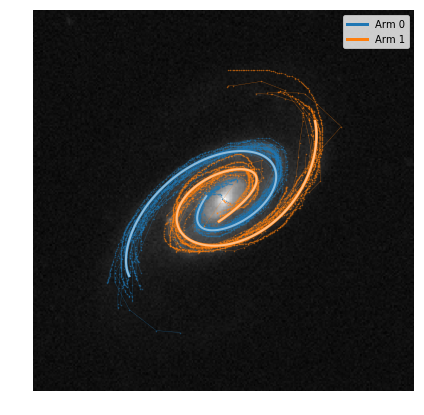

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))

plt.imshow(np.array(pic), cmap='gray', origin='lower')

t = np.linspace(0, 1, 1000)
for i, (Sx, Sy) in enumerate(res['functions']):
    for arm in drawnArms[res['labels'] == i]:
        plt.plot(
            arm[:, 0], arm[:, 1],
            '.-', c='C{}'.format(i),
            markersize=1, linewidth =0.4, alpha=0.5
        )
    plt.plot(
        deNormArm(Sx(t)), deNormArm(Sy(t)),
        c='C{}'.format(i), linewidth=3, label='Arm {}'.format(i)
    )
    plt.plot(
        deNormArm(Sx(t)), deNormArm(Sy(t)),
        c='w', linewidth=2, alpha=0.5
    )
_ = plt.axis('off')
plt.legend()

And now the same again but for the deprojected galaxy!

First, deproject the drawn arms and the resulting splines

In [16]:
deprojectedSplines = np.array([
    spiralExtraction.deprojectArm(
        angle - 90,
        gal['SERSIC_BA'],
        np.stack((Sx(t), Sy(t)), axis=1)
    )
    for Sx, Sy in res['functions']
])

deprojectedArms = np.array([
    spiralExtraction.deprojectArm(
        angle - 90,
        gal['SERSIC_BA'],
        arm / 512 - 0.5
    )
    for arm in drawnArms
])

Now plot in the same way as before

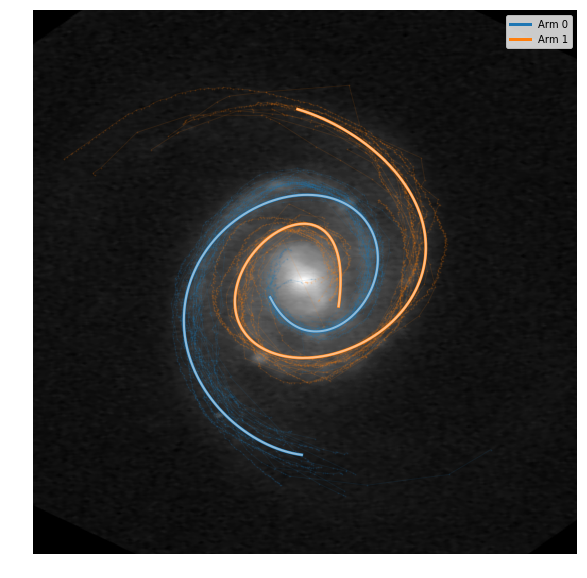

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(deprojectedImage, cmap='gray', origin='lower')

# plot deprojected point clouds
t = np.linspace(0, 1, 500)
for i in range(np.max(res['labels'] + 1)):
    for arm in deprojectedArms[res['labels'] == i]:
        plt.plot(
            *(512 * (arm.T+0.5)),
            '.-', c='C{}'.format(i),
            alpha=0.1, markersize=2, linewidth=1
        )
    
    arm = deprojectedSplines[i]
    plt.plot(
        *deNormArm(arm).T,
        c='C{}'.format(i), linewidth=3, label='Arm {}'.format(i)
    )
    plt.plot(
        *deNormArm(arm).T,
        c='w', linewidth=2, alpha=0.5
    )

plt.legend()
plt.axis('off')
None

I'm not convinced that this is the best way of fitting splines though (fitting for x and y in image coordinates and deprojecting the result).

Below I'll attempt to fit for x and y in deprojected coordinates, and also fit for R (which requires some trickery due to the nature of theta wrapping from $+\pi$ to $-\pi$) 

In [18]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

First, recreate the point cleaning and spline fitting from the pipeline

In [19]:
# choose which arm to work on
label = 1

# get the points for that arm and follow the normal fitting process (as spiralExtraction.fit)
pointCloud = deNormArm(np.array([
    point
    for arm in deprojectedArms[res['labels'] == label]
    for point in arm
]))

clf, LOFmask = spiralExtraction.cleanPoints(pointCloud)
cleanedCloud = pointCloud[LOFmask]

# choose our "representative arm" to be the previously fitted spline (coz it's nice and smooooth)
armyArm = deNormArm(deprojectedSplines[label])

deviationCloud = np.transpose(
    spiralExtraction.getDistAlongPolyline(cleanedCloud, armyArm)
)
deviationEnvelope = np.abs(deviationCloud[:, 1]) < 30

startEndMask = np.logical_and(
    deviationCloud[:, 0] > 0,
    deviationCloud[:, 0] < armyArm.shape[0]
)

totalMask = np.logical_and(deviationEnvelope, startEndMask)

# oder the points
pointOrder = np.argsort(deviationCloud[totalMask, 0])

# normalise from -0.5 to +0.5 for consistency in spline fit
normalisedPoints = cleanedCloud[totalMask][pointOrder] / 512
normalisedPoints -= 0.5

In [20]:
t = deviationCloud[totalMask, 0][pointOrder].copy()
t /= np.max(t)
mask = t[1:] - t[:-1] <= 0
while np.any(mask):
    mask = t[1:] - t[:-1] <= 0
    t[1:][mask] += 0.0001

In [21]:
Sx = UnivariateSpline(t, normalisedPoints[:, 0], k=5)
Sy = UnivariateSpline(t, normalisedPoints[:, 1], k=5)

In [22]:
from scipy.interpolate import interp1d

r, theta = spiralExtraction.rThetaFromXY(
    normalisedPoints[:, 0],
    normalisedPoints[:, 1],
    mux=0, muy=0
)
aaR, aaTh = spiralExtraction.rThetaFromXY(
    *(armyArm.T / 512 - 0.5)
)

foo = np.linspace(min(t), max(t), aaTh.shape[0])
tFunc = interp1d(foo, aaTh)

r, theta = spiralExtraction.rThetaFromXY(
    normalisedPoints[:, 0],
    normalisedPoints[:, 1],
    mux=0, muy=0
)
bar = np.linspace(0.1, 1, 1000)
Sr = UnivariateSpline(t, r, k=5)
xr, yr = spiralExtraction.xyFromRTheta(Sr(foo), tFunc(foo), mux=0, muy=0)


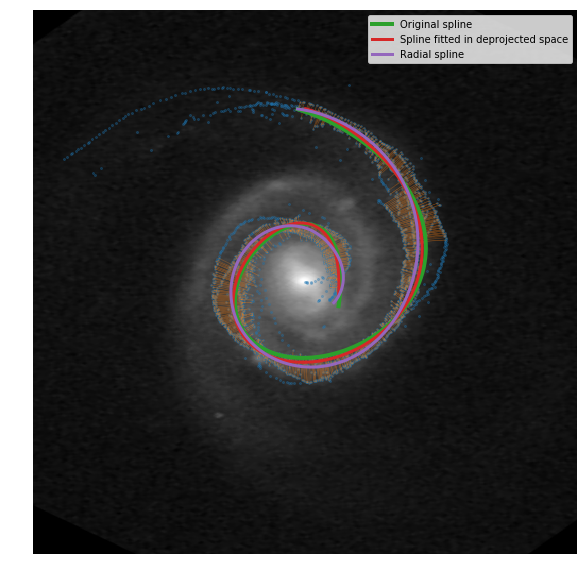

In [52]:
plt.figure(figsize=(10, 10))
plt.imshow(deprojectedImage, cmap='gray', origin='lower')
t2 = np.linspace(0, 1, 500)

plt.plot(*pointCloud.T, '.', markersize=4, alpha=0.3)
plt.plot(
    *deNormArm(normalisedPoints).T,
    '.-', markersize=1, linewidth=0.5, alpha=0.3
)
plt.plot(
    *deNormArm(deprojectedSplines[label]).T,
    label='Original spline',
    linewidth=4
)
plt.plot(
    *[deNormArm(f) for f in (Sx(t2), Sy(t2))],
    linewidth=3,
    label='Spline fitted in deprojected space'
)

plt.plot(
    *deNormArm(np.array([xr, yr])),
    label='Radial spline',
    linewidth=3
)
plt.axis('off')
plt.legend()
None

(-0.5, 255.5, -0.5, 255.5)

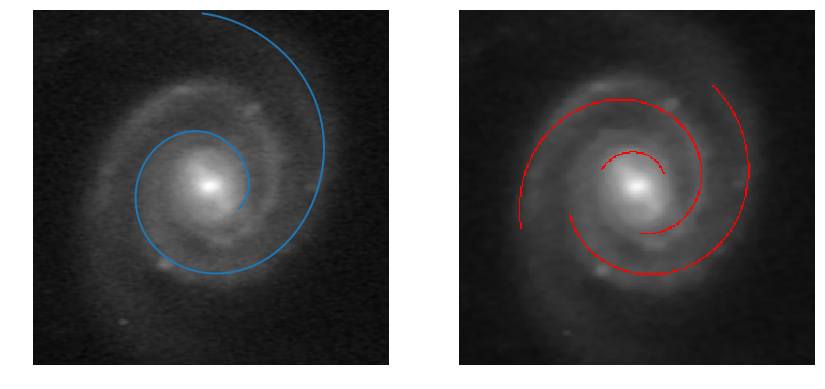

In [87]:
plt.figure(figsize=(14, 7))
sparcfireDir = 'sparcfire_galaxy_image_11_data'
sparcfireFile = 'image_11-J_logSpiralArcs-merged.png'
pic = Image.open('./{}/{}'.format(sparcfireDir, sparcfireFile))
plt.subplot(121)
plt.imshow(deprojectedImage, cmap='gray', origin='lower')
plt.plot(
    *deNormArm(np.array([xr, yr])),
    label='Radial spline',
    linewidth=2
)
plt.axis('off')
plt.xlim(90, 512-90)
plt.ylim(90, 512-90)
plt.subplot(122)
plt.imshow(np.array(pic)[::-1, ::-1], origin='lower')
plt.axis('off')